# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/cnn_dropout'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define CNN based auto-encoder

- 64 * 64 * 3 image input = 12,288
- Cov3 with 32 channel, 3 * 3 * 3 * 32 = 864 parameters
- ReLU
- MaxPool -> 32 * 32 * 32 hidden state = 32768
- Cov3 with 64 channel, 32 * 3 * 3 * 64 = 18432 parameters
- ReLU
- MaxPool -> 16 * 16 * 64 hidden state = 16384
- Cov3 with 128 channel, 64 * 3 * 3 * 128 = 73728 parameters
- ReLU
- MaxPool -> 8 * 8 * 128 = 8192 hidden state
- Full connected 8192 -> **embedding size**

And the decoder works reversely.

In [2]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, embedding_size=32, dropout_rate=0.25):
        super(Autoencoder, self).__init__()
        self.embedding_size = embedding_size
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout_rate),
        )
        self.fc1 = nn.Linear(8 * 8 * 128, self.embedding_size)  # Fully connected layer to get 32-length embedding

        # Decoder
        self.fc2 = nn.Linear(self.embedding_size, 8 * 8 * 128)  # Fully connected layer to reshape back to 8x8x128
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten the tensor
        encoded = self.fc1(encoded)  # Get the embedding
        decoded = self.fc2(encoded)  # Reshape back to 8x8x128
        decoded = decoded.view(decoded.size(0), 128, 8, 8)
        decoded = self.decoder(decoded)
        return decoded, encoded

In [3]:
from util import train_model_steps, plot_model, count_parameters, calculate_metrics, save_to_file, load_from_file, print_matrix, plot_conf_matrix

def train_model(embedding_size=32, dropout_rate=0.25, learning_rate=1e-4, weight_decay=1e-5, num_epochs=20):
    # Initialize the model
    model = Autoencoder(embedding_size=embedding_size, dropout_rate=dropout_rate)
    print(f'Number of parameters: {count_parameters(model)}')

    model_path = f'{MODEL_PATH}/e{embedding_size}.pth'
    stat_path = f'{MODEL_PATH}/e{embedding_size}.pkl'
    if os.path.exists(model_path) and os.path.exists(stat_path):
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        train_losses, test_losses = load_from_file(stat_path)
    else:
        model, train_losses, test_losses = train_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
        # Save the model
        torch.save(model.state_dict(), model_path)
        save_to_file((train_losses, test_losses), stat_path)

    metrics = calculate_metrics(model, testset)
    print_matrix(metrics)
    plot_conf_matrix(metrics['conf_matrix'])
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from 8192)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 407687
Epoch [1/20], Train Loss: 0.3012, Test Loss: 0.2158
Epoch [2/20], Train Loss: 0.1534, Test Loss: 0.1470
Epoch [3/20], Train Loss: 0.1401, Test Loss: 0.1450
Epoch [4/20], Train Loss: 0.1374, Test Loss: 0.1437
Epoch [5/20], Train Loss: 0.1350, Test Loss: 0.1380
Epoch [6/20], Train Loss: 0.1324, Test Loss: 0.1361
Epoch [7/20], Train Loss: 0.1306, Test Loss: 0.1360
Epoch [8/20], Train Loss: 0.1287, Test Loss: 0.1337
Epoch [9/20], Train Loss: 0.1269, Test Loss: 0.1308
Epoch [10/20], Train Loss: 0.1253, Test Loss: 0.1309
Epoch [11/20], Train Loss: 0.1242, Test Loss: 0.1305
Epoch [12/20], Train Loss: 0.1236, Test Loss: 0.1295
Epoch [13/20], Train Loss: 0.1229, Test Loss: 0.1306
Epoch [14/20], Train Loss: 0.1223, Test Loss: 0.1291
Epoch [15/20], Train Loss: 0.1220, Test Loss: 0.1286
Epoch [16/20], Train Loss: 0.1217, Test Loss: 0.1280
Epoch [17/20], Train Loss: 0.1213, Test Loss: 0.1276
Epoch [18/20], Train Loss: 0.1211, Test Loss: 0.1281
Epoch [19/20], Train Loss:

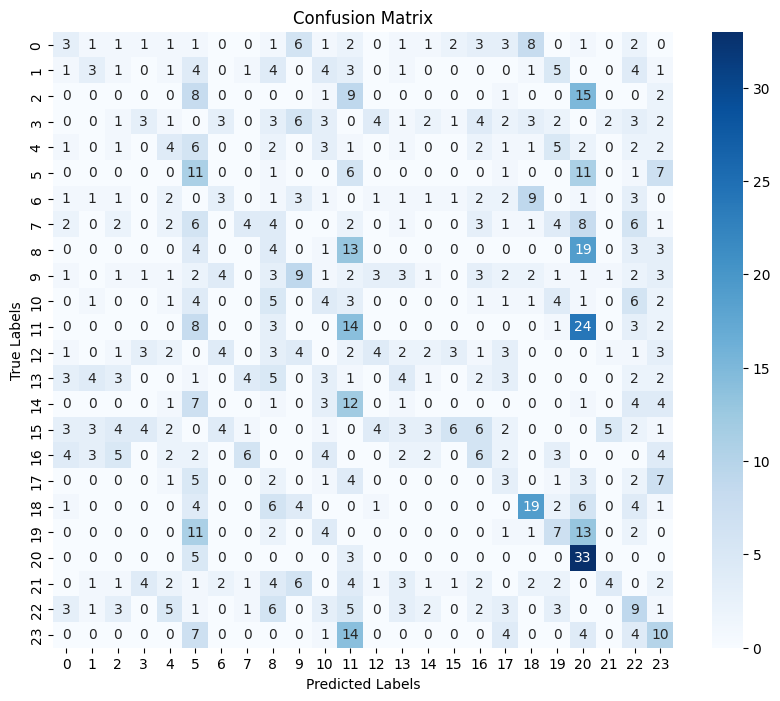

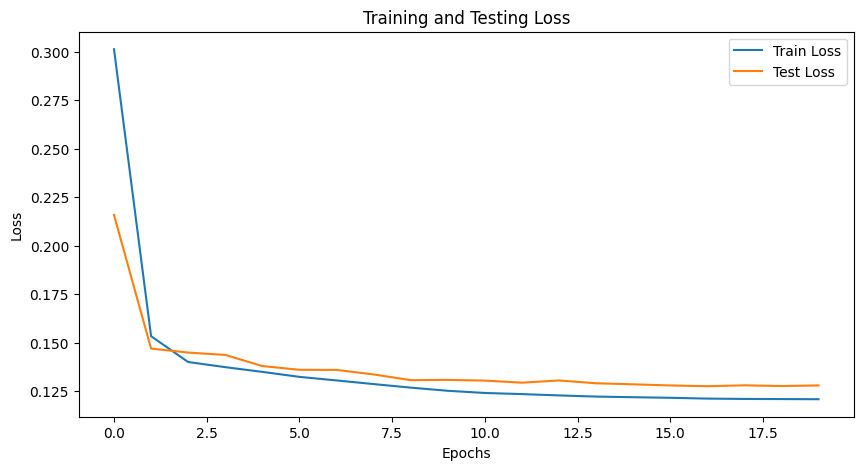

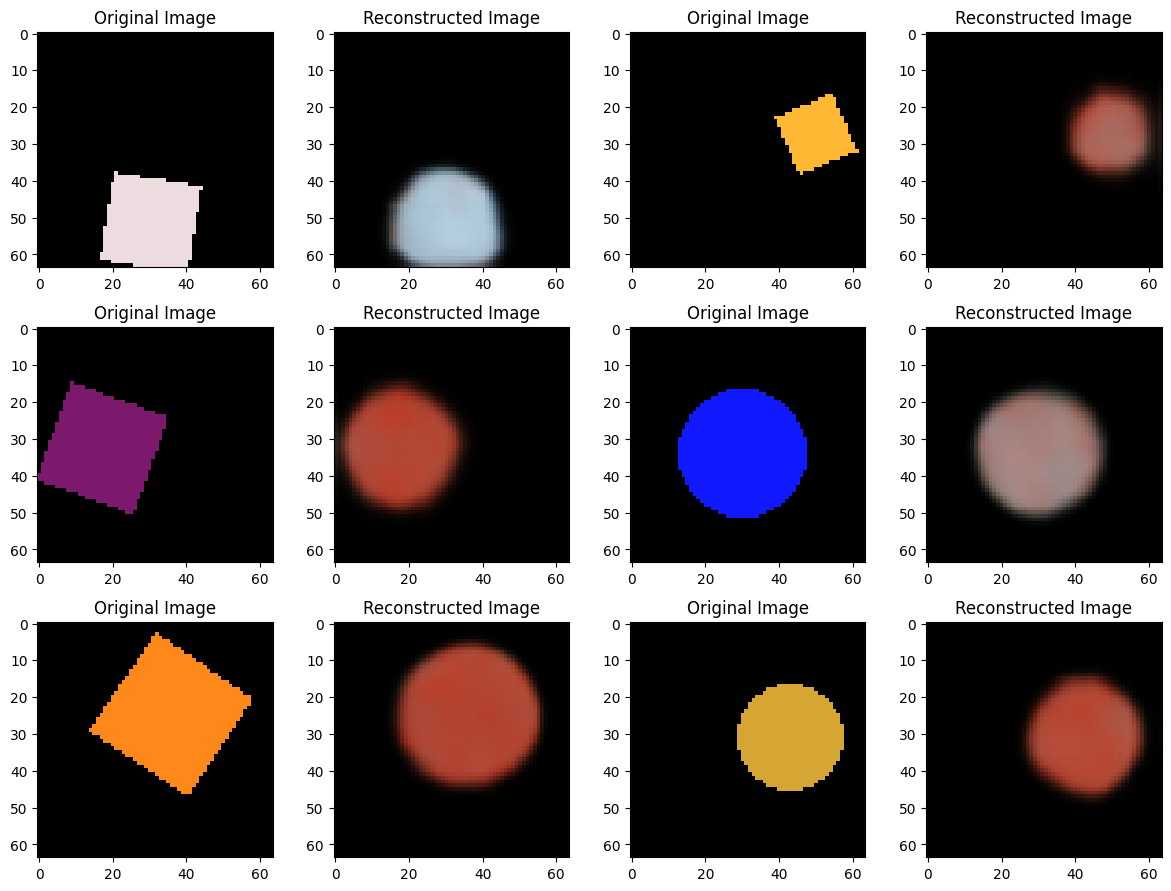

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.1, inplace=False)
     (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU()
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Dropout(p=0.1, inplace=False)
   )
   (fc1): Linear(in_features=8192, out_features=4, bias=True)
   (fc2): Linear(in_features=4, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
 

In [4]:
train_model(embedding_size=4, dropout_rate=0.1)

Number of parameters: 473227
Epoch [1/20], Train Loss: 0.3080, Test Loss: 0.2278
Epoch [2/20], Train Loss: 0.1545, Test Loss: 0.1479
Epoch [3/20], Train Loss: 0.1393, Test Loss: 0.1419
Epoch [4/20], Train Loss: 0.1355, Test Loss: 0.1400
Epoch [5/20], Train Loss: 0.1317, Test Loss: 0.1359
Epoch [6/20], Train Loss: 0.1263, Test Loss: 0.1255
Epoch [7/20], Train Loss: 0.1180, Test Loss: 0.1199
Epoch [8/20], Train Loss: 0.1118, Test Loss: 0.1143
Epoch [9/20], Train Loss: 0.1090, Test Loss: 0.1109
Epoch [10/20], Train Loss: 0.1069, Test Loss: 0.1090
Epoch [11/20], Train Loss: 0.1053, Test Loss: 0.1080
Epoch [12/20], Train Loss: 0.1039, Test Loss: 0.1067
Epoch [13/20], Train Loss: 0.1028, Test Loss: 0.1053
Epoch [14/20], Train Loss: 0.1019, Test Loss: 0.1058
Epoch [15/20], Train Loss: 0.1011, Test Loss: 0.1052
Epoch [16/20], Train Loss: 0.1006, Test Loss: 0.1047
Epoch [17/20], Train Loss: 0.1002, Test Loss: 0.1042
Epoch [18/20], Train Loss: 0.0997, Test Loss: 0.1041
Epoch [19/20], Train Loss:

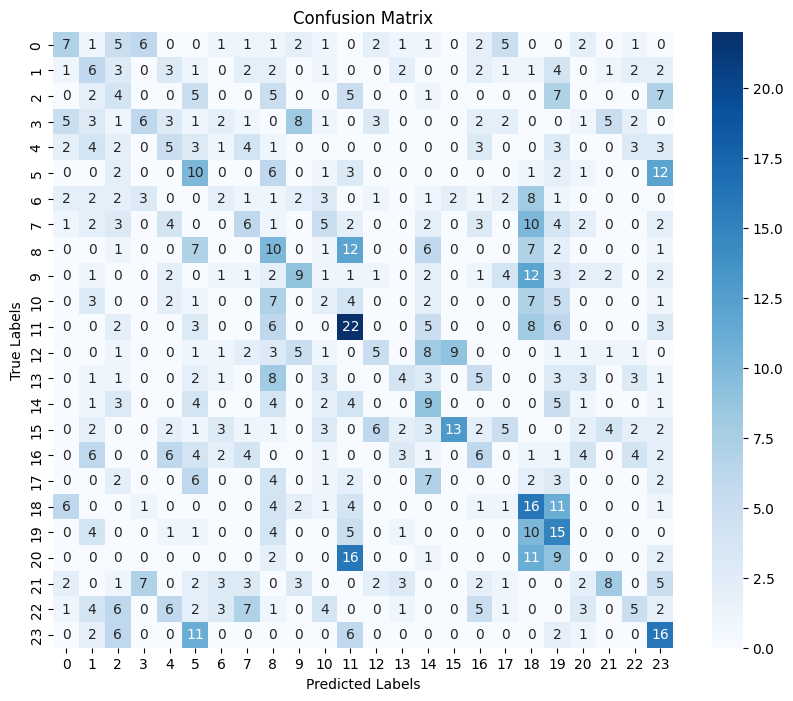

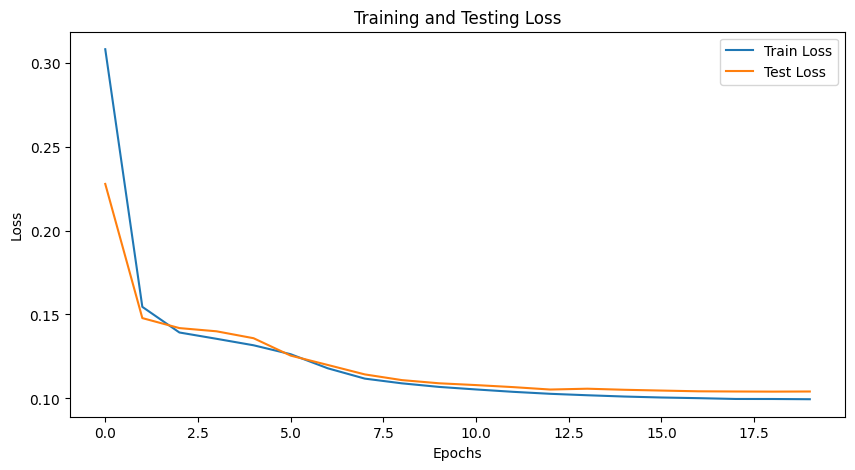

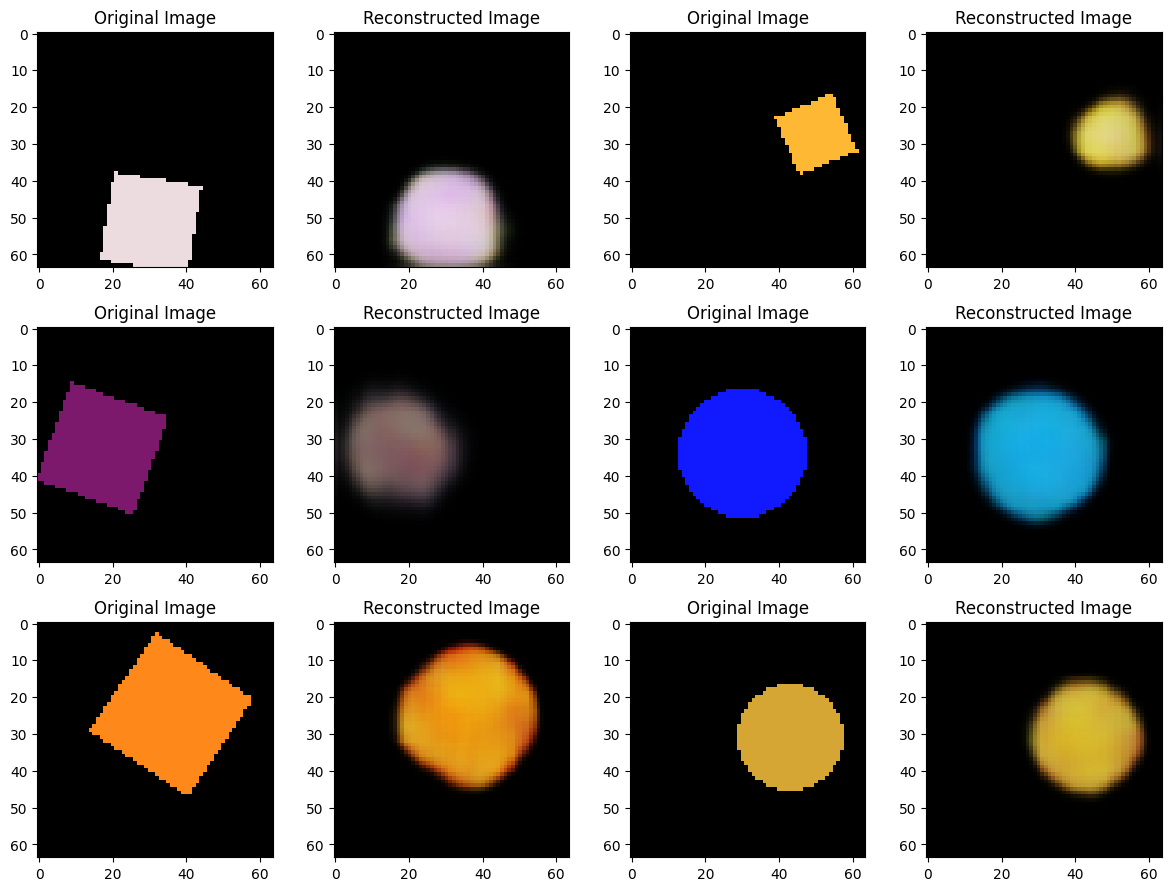

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.1, inplace=False)
     (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU()
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Dropout(p=0.1, inplace=False)
   )
   (fc1): Linear(in_features=8192, out_features=8, bias=True)
   (fc2): Linear(in_features=8, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')
 

In [5]:
train_model(embedding_size=8, dropout_rate=0.1)

Number of parameters: 604307
Epoch [1/20], Train Loss: 0.2826, Test Loss: 0.1604
Epoch [2/20], Train Loss: 0.1435, Test Loss: 0.1450
Epoch [3/20], Train Loss: 0.1376, Test Loss: 0.1418
Epoch [4/20], Train Loss: 0.1343, Test Loss: 0.1389
Epoch [5/20], Train Loss: 0.1314, Test Loss: 0.1380
Epoch [6/20], Train Loss: 0.1274, Test Loss: 0.1323
Epoch [7/20], Train Loss: 0.1213, Test Loss: 0.1225
Epoch [8/20], Train Loss: 0.1148, Test Loss: 0.1145
Epoch [9/20], Train Loss: 0.1082, Test Loss: 0.1102
Epoch [10/20], Train Loss: 0.1044, Test Loss: 0.1078
Epoch [11/20], Train Loss: 0.1021, Test Loss: 0.1064
Epoch [12/20], Train Loss: 0.1004, Test Loss: 0.1035
Epoch [13/20], Train Loss: 0.0992, Test Loss: 0.1032
Epoch [14/20], Train Loss: 0.0981, Test Loss: 0.1028
Epoch [15/20], Train Loss: 0.0972, Test Loss: 0.1017
Epoch [16/20], Train Loss: 0.0965, Test Loss: 0.1012
Epoch [17/20], Train Loss: 0.0960, Test Loss: 0.1012
Epoch [18/20], Train Loss: 0.0957, Test Loss: 0.1002
Epoch [19/20], Train Loss:

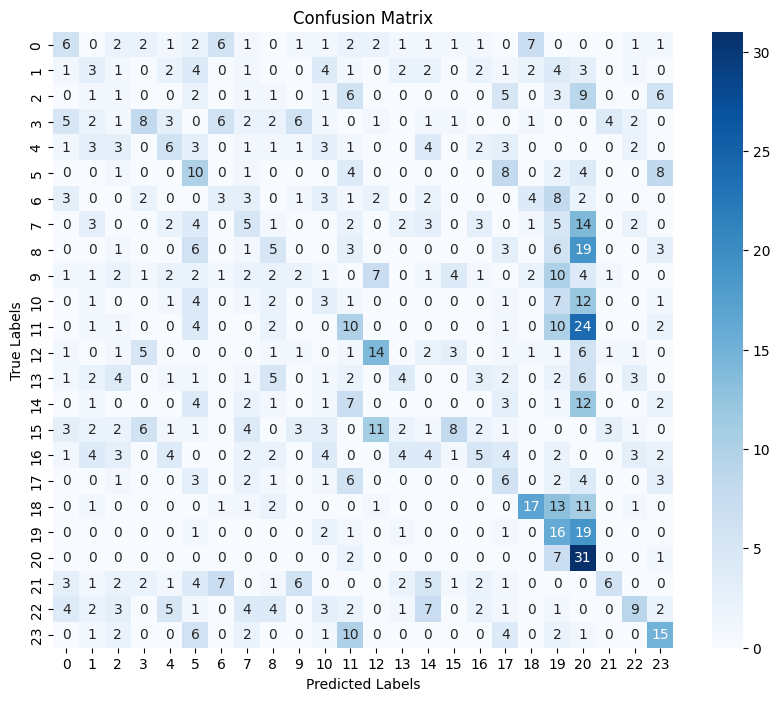

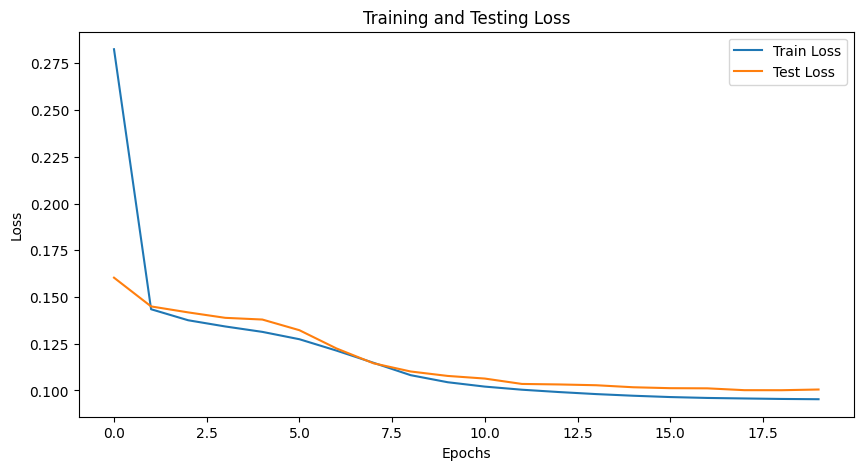

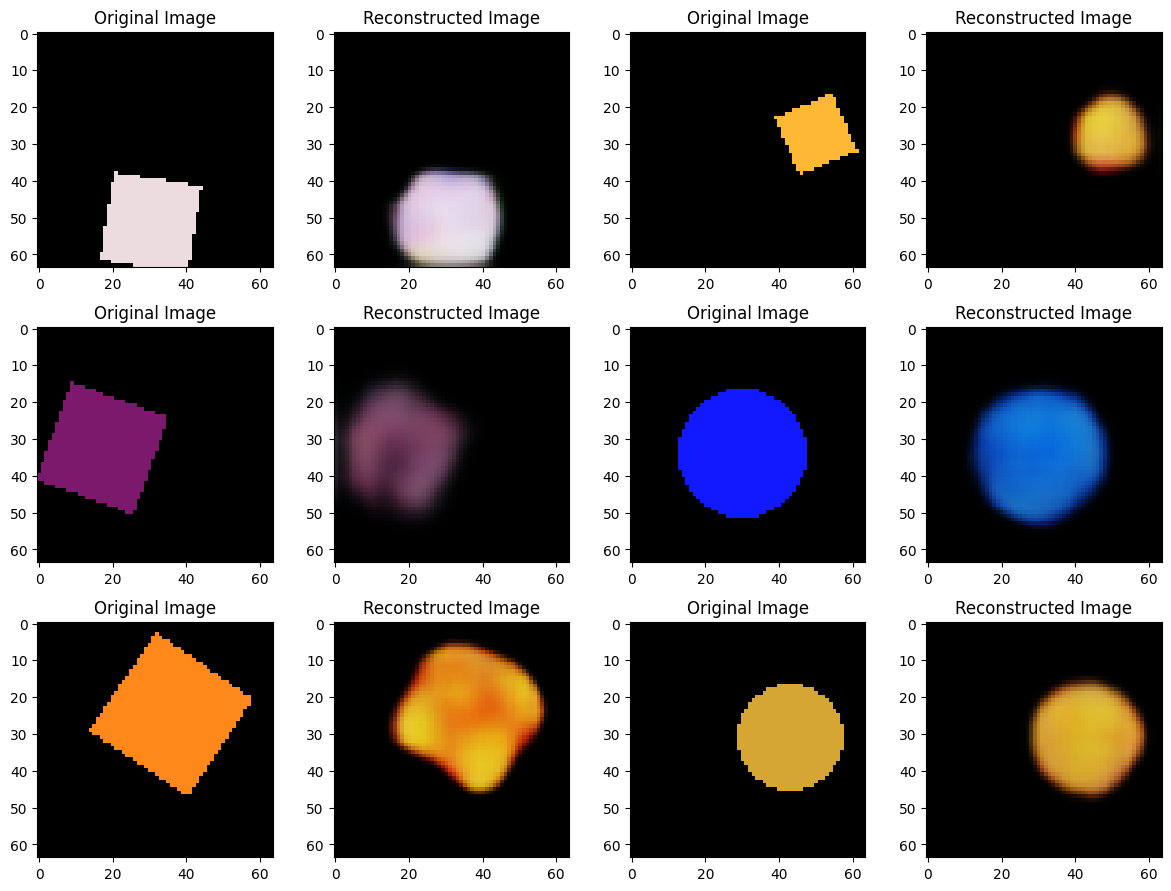

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.1, inplace=False)
     (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU()
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Dropout(p=0.1, inplace=False)
   )
   (fc1): Linear(in_features=8192, out_features=16, bias=True)
   (fc2): Linear(in_features=16, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')

In [6]:
train_model(embedding_size=16, dropout_rate=0.1)

Number of parameters: 866467
Epoch [1/20], Train Loss: 0.2926, Test Loss: 0.1617
Epoch [2/20], Train Loss: 0.1432, Test Loss: 0.1459
Epoch [3/20], Train Loss: 0.1362, Test Loss: 0.1380
Epoch [4/20], Train Loss: 0.1318, Test Loss: 0.1334
Epoch [5/20], Train Loss: 0.1275, Test Loss: 0.1290
Epoch [6/20], Train Loss: 0.1220, Test Loss: 0.1227
Epoch [7/20], Train Loss: 0.1131, Test Loss: 0.1108
Epoch [8/20], Train Loss: 0.1053, Test Loss: 0.1076
Epoch [9/20], Train Loss: 0.1020, Test Loss: 0.1042
Epoch [10/20], Train Loss: 0.0997, Test Loss: 0.1038
Epoch [11/20], Train Loss: 0.0978, Test Loss: 0.1005
Epoch [12/20], Train Loss: 0.0960, Test Loss: 0.0988
Epoch [13/20], Train Loss: 0.0945, Test Loss: 0.0975
Epoch [14/20], Train Loss: 0.0933, Test Loss: 0.0970
Epoch [15/20], Train Loss: 0.0925, Test Loss: 0.0957
Epoch [16/20], Train Loss: 0.0916, Test Loss: 0.0957
Epoch [17/20], Train Loss: 0.0912, Test Loss: 0.0950
Epoch [18/20], Train Loss: 0.0907, Test Loss: 0.0944
Epoch [19/20], Train Loss:

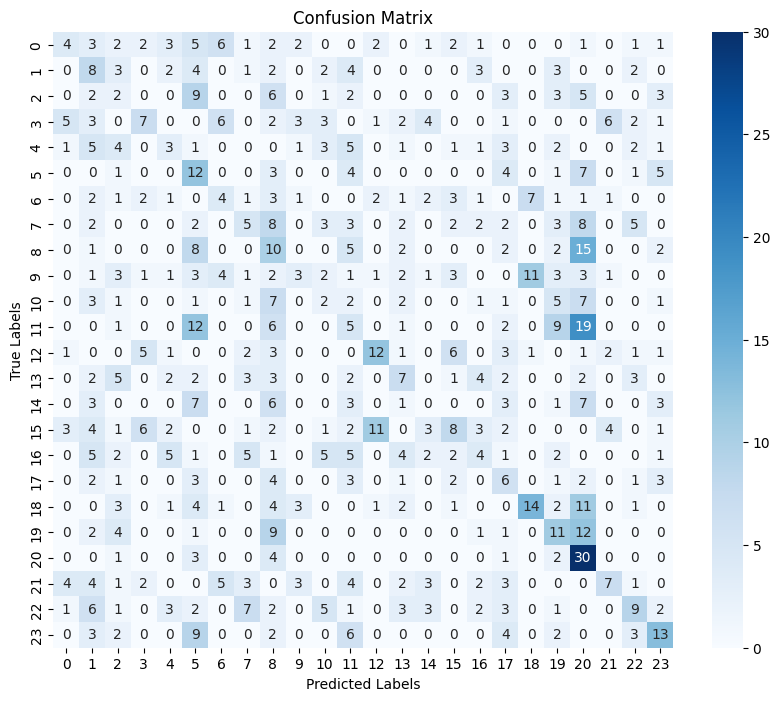

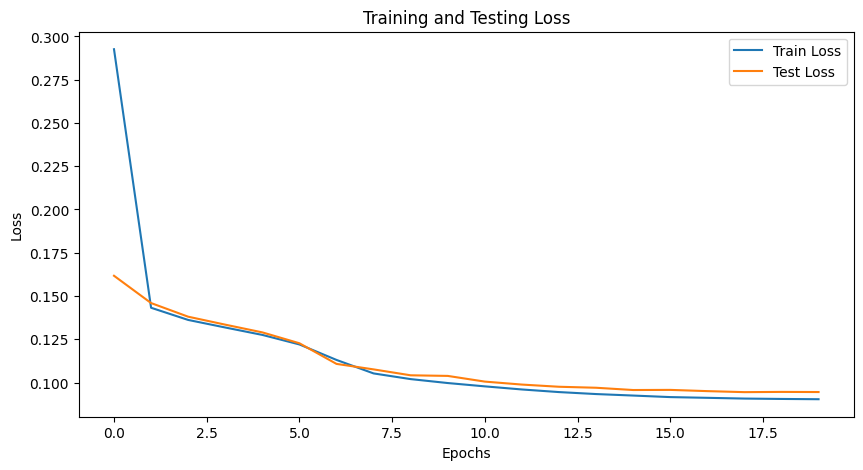

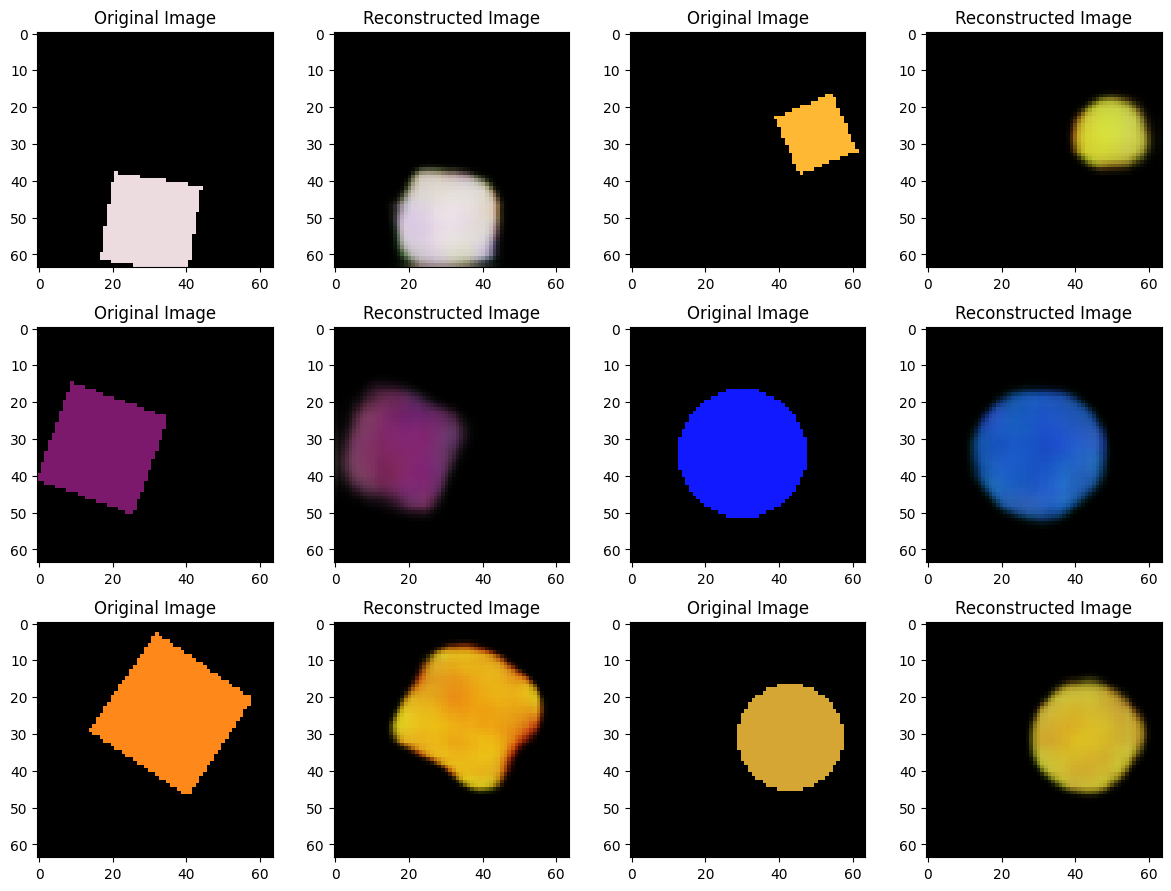

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.1, inplace=False)
     (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU()
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Dropout(p=0.1, inplace=False)
   )
   (fc1): Linear(in_features=8192, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')

In [7]:
train_model(embedding_size=32, dropout_rate=0.1)

Number of parameters: 1390787
Epoch [1/20], Train Loss: 0.3003, Test Loss: 0.1654
Epoch [2/20], Train Loss: 0.1447, Test Loss: 0.1441
Epoch [3/20], Train Loss: 0.1371, Test Loss: 0.1390
Epoch [4/20], Train Loss: 0.1310, Test Loss: 0.1348
Epoch [5/20], Train Loss: 0.1233, Test Loss: 0.1218
Epoch [6/20], Train Loss: 0.1127, Test Loss: 0.1121
Epoch [7/20], Train Loss: 0.1069, Test Loss: 0.1078
Epoch [8/20], Train Loss: 0.1033, Test Loss: 0.1065
Epoch [9/20], Train Loss: 0.1006, Test Loss: 0.1030
Epoch [10/20], Train Loss: 0.0984, Test Loss: 0.1003
Epoch [11/20], Train Loss: 0.0959, Test Loss: 0.0980
Epoch [12/20], Train Loss: 0.0939, Test Loss: 0.0973
Epoch [13/20], Train Loss: 0.0921, Test Loss: 0.0963
Epoch [14/20], Train Loss: 0.0905, Test Loss: 0.0936
Epoch [15/20], Train Loss: 0.0892, Test Loss: 0.0928
Epoch [16/20], Train Loss: 0.0886, Test Loss: 0.0918
Epoch [17/20], Train Loss: 0.0880, Test Loss: 0.0917
Epoch [18/20], Train Loss: 0.0876, Test Loss: 0.0916
Epoch [19/20], Train Loss

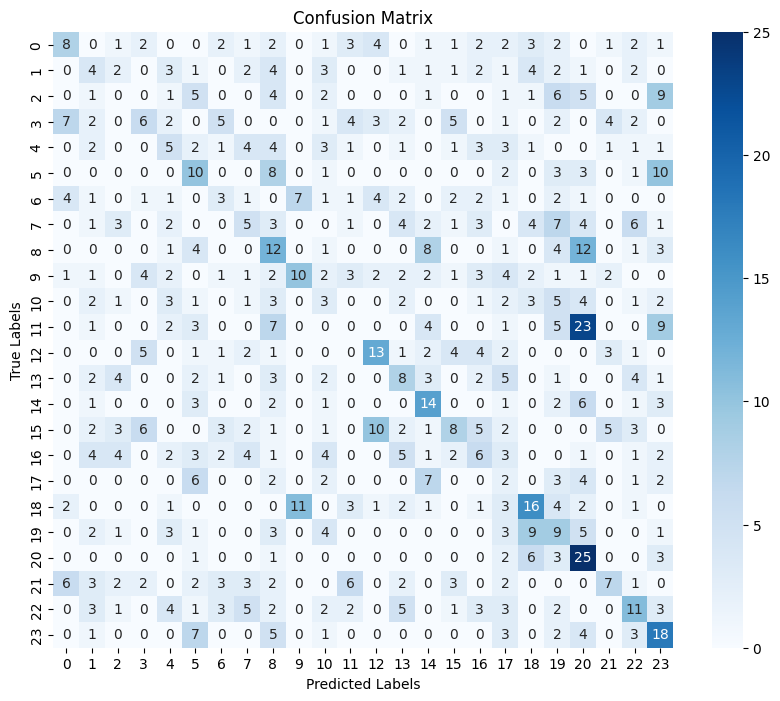

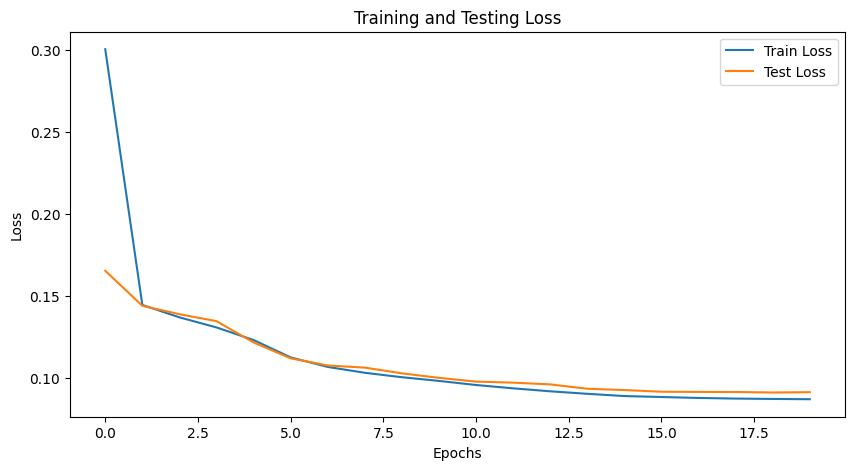

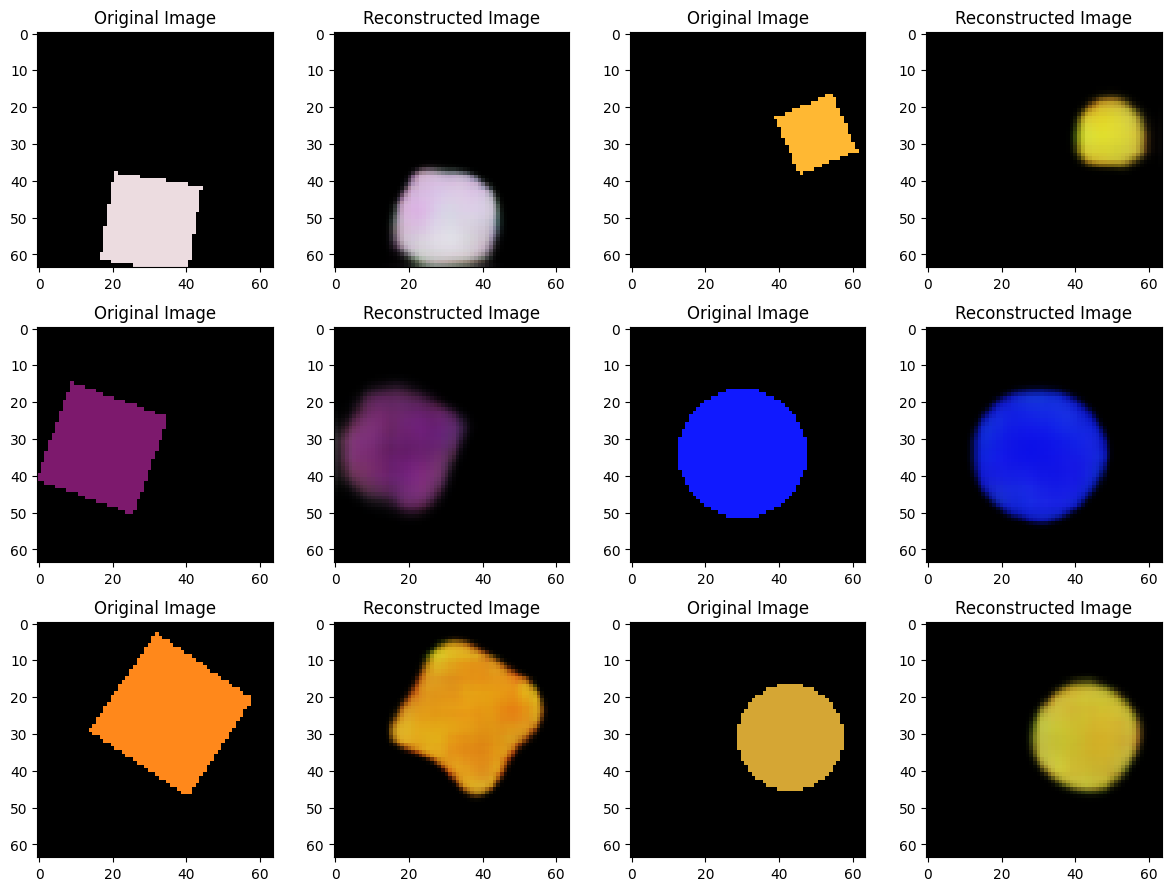

(Autoencoder(
   (encoder): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Dropout(p=0.1, inplace=False)
     (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.1, inplace=False)
     (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU()
     (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (11): Dropout(p=0.1, inplace=False)
   )
   (fc1): Linear(in_features=8192, out_features=64, bias=True)
   (fc2): Linear(in_features=64, out_features=8192, bias=True)
   (decoder): Sequential(
     (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Upsample(scale_factor=2.0, mode='nearest')

In [8]:
train_model(embedding_size=64, dropout_rate=0.1)